# Exploration of GDELT Dataset

## Executive Summary

< Problem statement>

< Introduce dataset>

< Introduce models used>

< Present important results>

< Communicate relevant insights>

## Introduction

< Stated the source of the data and introduced it to provide a complete
context for understanding the rest of the report>

< Has an explicit and clearly stated problem statement>

< Has an explicit and convincing motivation statement>

## Data Collection and Description

< – Described the data format and provided some relevant metadata that
allow the reader to clearly understand the data processing code>

In [1]:
# importing packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import dask.dataframe as dd
import dask.bag as db
from dask.delayed import delayed
from dask.distributed import Client
from sklearn.externals.joblib import parallel_backend
from dask.diagnostics import ProgressBar

## Exploratory Data Analysis

< Performed complete exploratory data analysis that are fully explained>

< All figures are properly labeled and captioned>

In [2]:
# set to run Dask commands in this "cluster"
client = Client('10.233.29.219:8786')

In [3]:
# check the contents of the folder
path = '/mnt/data/public/gdeltv2/*'
glob.glob(path)

['/mnt/data/public/gdeltv2/20170101190000.mentions.CSV.zip',
 '/mnt/data/public/gdeltv2/20170131134500.gkg.csv.zip',
 '/mnt/data/public/gdeltv2/20170210224500.mentions.CSV.zip',
 '/mnt/data/public/gdeltv2/20170213203000.gkg.csv.zip',
 '/mnt/data/public/gdeltv2/20170215044500.export.CSV.zip',
 '/mnt/data/public/gdeltv2/20170225004500.mentions.CSV.zip',
 '/mnt/data/public/gdeltv2/20170407133000.mentions.CSV.zip',
 '/mnt/data/public/gdeltv2/20170412044500.mentions.CSV.zip',
 '/mnt/data/public/gdeltv2/20170418044500.mentions.CSV.zip',
 '/mnt/data/public/gdeltv2/20170427171500.mentions.CSV.zip',
 '/mnt/data/public/gdeltv2/20170506113000.export.CSV.zip',
 '/mnt/data/public/gdeltv2/20170511183000.export.CSV.zip',
 '/mnt/data/public/gdeltv2/20170516070000.export.CSV.zip',
 '/mnt/data/public/gdeltv2/20170518223000.export.CSV.zip',
 '/mnt/data/public/gdeltv2/20170528044500.mentions.CSV.zip',
 '/mnt/data/public/gdeltv2/20170528213000.export.CSV.zip',
 '/mnt/data/public/gdeltv2/20170602141500.gkg.

In [4]:
# we see three kinds of files
# let's open the contents one by one

# we define sample sets
f1 = ['/mnt/data/public/gdeltv2/20170611004500.mentions.CSV.zip']
f2 = ['/mnt/data/public/gdeltv2/20170611004500.export.CSV.zip']
f3 = ['/mnt/data/public/gdeltv2/20170611004500.gkg.csv.zip']

# we import the progress bar
# pbar = ProgressBar()
# pbar.register()

# we load mentions.CSV.zip into a delayed Pandas dataframe

dfs = [delayed(pd.read_csv)(fn, delimiter='\t', header=None,
                            dtype='str', engine='python') for fn in f1]
df = dd.from_delayed(dfs)
print(f1)
display(df.head().T)

# we load export.CSV.zip into a delayed Pandas dataframe

dfs = [delayed(pd.read_csv)(fn, delimiter='\t', header=None,
                            dtype='str', engine='python') for fn in f2]
df = dd.from_delayed(dfs)
print(f2)
display(df.head().T)

# we load gkg.CSV.zip into a delayed Pandas dataframe

dfs = [delayed(pd.read_csv)(fn, delimiter='\t', header=None,
                            dtype='str', engine='python') for fn in f3]
df = dd.from_delayed(dfs)
print(f3)
display(df.head().T)

['/mnt/data/public/gdeltv2/20170611004500.mentions.CSV.zip']


,0,1,2,3,4
0,549285546,549255686,549316095,549316095,663766551
1,20160611023000,20160611001500,20160611053000,20160611053000,20170611004500
2,20170611004500,20170611004500,20170611004500,20170611004500,20170611004500
3,1,1,1,1,1
4,nbcnews.com,nbcnews.com,cbs8.com,kaaltv.com,nbcnews.com
5,http://www.nbcnews.com/news/us-news/jeff-sessi...,http://www.nbcnews.com/news/us-news/jeff-sessi...,http://www.cbs8.com/story/35635737/london-brid...,http://www.KAALtv.com/world/london-bridge-atta...,http://www.nbcnews.com/storyline/isis-uncovere...
6,28,28,6,6,10
7,-1,-1,1174,1149,2894
8,5102,5102,-1,-1,2922
9,5060,5060,1122,1097,2909


['/mnt/data/public/gdeltv2/20170611004500.export.CSV.zip']


,0,1,2,3,4
0,663766551,663766552,663766553,663766554,663766555
1,20160611,20160611,20160611,20160611,20160611
2,201606,201606,201606,201606,201606
3,2016,2016,2016,2016,2016
4,2016.4411,2016.4411,2016.4411,2016.4411,2016.4411
5,REB,USA,USA,USA,USA
6,SUICIDE BOMBER,UNITED STATES,THE US,UNITED STATES,UNITED STATES
7,nan,USA,USA,USA,USA
8,nan,nan,nan,nan,nan
9,nan,nan,nan,nan,nan


['/mnt/data/public/gdeltv2/20170611004500.gkg.csv.zip']


,0,1,2,3,4
0,20170611004500-0,20170611004500-1,20170611004500-2,20170611004500-3,20170611004500-4
1,20170611004500,20170611004500,20170611004500,20170611004500,20170611004500
2,1,1,1,1,1
3,dailyexcelsior.com,thebusinessjournal.com,therepublic.com,echonews.com.au,borderwatch.com.au
4,http://www.dailyexcelsior.com/ddc-kupwara-insp...,http://www.thebusinessjournal.com/news/constru...,http://www.therepublic.com/2017/06/10/us-comey...,https://www.echonews.com.au/news/going-electri...,http://www.borderwatch.com.au/story/4721481/pe...
5,nan,nan,nan,nan,nan
6,nan,nan,nan,nan,nan
7,GENERAL_HEALTH;MEDICAL;SOC_POINTSOFINTEREST;SO...,MANMADE_DISASTER_IMPLIED;TAX_FNCACT;TAX_FNCACT...,TAX_FNCACT;TAX_FNCACT_DIRECTOR;LEADER;TAX_FNCA...,MANMADE_DISASTER_IMPLIED;,nan
8,"ECON_STOCKMARKET,1471;TAX_FNCACT_PARAMEDICS,60...","TAX_FNCACT_BUILDER,675;ECON_HOUSING_PRICES,533...","TAX_FNCACT_DEPUTY,4410;TAX_POLITICAL_PARTY_REP...","MANMADE_DISASTER_IMPLIED,224;MANMADE_DISASTER_...",nan
9,"4#Kupwara, Jammu And Kashmir, India#IN#IN12#34...","2#California, United States#US#USCA#36.17#-119...","2#New York, United States#US#USNY#42.1497#-74....","4#Ewingsdale, New South Wales, Australia#AS#AS...","4#Penrith, New South Wales, Australia#AS#AS02#..."


In [5]:
# We see that there are no columns in the dataset
# We found the columns in GDELT website

events_columns = ['GlobalEventID', 'Day', 'MonthYear', 'Year', 'FractionDate',
                  'Actor1Code', 'Actor1Name', 'Actor1CountryCode',
                  'Actor1KnownGroupCode', 'Actor1EthnicCode',
                  'Actor1Religion1Code', 'Actor1Religion2Code',
                  'Actor1Type1Code', 'Actor1Type2Code', 'Actor1Type3Code',
                  'Actor2Code', 'Actor2Name', 'Actor2CountryCode',
                  'Actor2KnownGroupCode', 'Actor2EthnicCode',
                  'Actor2Religion1Code', 'Actor2Religion2Code',
                  'Actor2Type1Code', 'Actor2Type2Code', 'Actor2Type3Code',
                  'IsRootEvent', 'EventCode', 'EventBaseCode',
                  'EventRootCode', 'QuadClass', 'GoldsteinScale',
                  'NumMentions', 'NumSources', 'NumArticles', 'AvgTone',
                  'Actor1Geo_Type', 'Actor1Geo_Fullname',
                  'Actor1Geo_CountryCode', 'Actor1Geo_ADM1Code',
                  'Actor1Geo_ADM2Code', 'Actor1Geo_Lat', 'Actor1Geo_Long',
                  'Actor1Geo_FeatureID', 'Actor2Geo_Type',
                  'Actor2Geo_Fullname', 'Actor2Geo_CountryCode',
                  'Actor2Geo_ADM1Code', 'Actor2Geo_ADM2Code',
                  'Actor2Geo_Lat', 'Actor2Geo_Long', 'Actor2Geo_FeatureID',
                  'ActionGeo_Type', 'ActionGeo_Fullname',
                  'ActionGeo_CountryCode', 'ActionGeo_ADM1Code',
                  'ActionGeo_ADM2Code', 'ActionGeo_Lat', 'ActionGeo_Long',
                  'ActionGeo_FeatureID', 'DATEADDED', 'SOURCEURL']
gkg_columns = ['GKGRECORDID', 'V2.1DATE', 'V2SOURCECOLLECTIONIDENTIFIER', 'V2SOURCECOMMONNAME',
               'V2DOCUMENTIDENTIFIER', 'V1COUNTS', 'V2.1COUNTS', 'V1THEMES', 'V2ENHANCEDTHEMES',
               'V1LOCATIONS', 'V2ENHANCEDLOCATIONS', 'V1PERSONS', 'V2ENHANCEDPERSONS',
               'V1ORGANIZATIONS', 'V2ENHANCEDORGANIZATIONS', 'V1.5TONE', 'V2.1ENHANCEDDATES',
               'V2GCAM', 'V2.1SHARINGIMAGE', 'V2.1RELATEDIMAGES', 'V2.1SOCIALIMAGEEMBEDS',
               'V2.1SOCIALVIDEOEMBEDS', 'V2.1QUOTATIONS', 'V2.1ALLNAMES', 'V2.1AMOUNTS',
               'V2.1TRANSLATIONINFO', 'V2EXTRASXML']

In [6]:
# We are ready to load a larger dataset

# Import regex
import re

# we import the progress bar
pbar = ProgressBar()
pbar.register()

def load_events(filenames):
    '''
    Load events data from list of filenames
    Select necessary columns, drop null values
    Convert numerical values to float
    Return the cleaned dask dataframe
    '''
    f_events = filenames

    # we load export.CSV.zip into a delayed Pandas dataframe
    dfs_events = [delayed(pd.read_csv)(fn, delimiter='\t', header=None,
                                       dtype='str', names=events_columns, engine='python') for fn in f_events]
    df_events = dd.from_delayed(dfs_events).set_index('GlobalEventID')

    # Drop null values
    df_events = df_events.dropna(
        subset=['GoldsteinScale', 'NumMentions', 'AvgTone', 'Actor1Geo_Lat', 'Actor1Geo_Long', 'Actor1Geo_CountryCode', 'Actor1Geo_Fullname'])
    print("> Null values dropped.")

    # Numerical datapoints to clean
    to_clean = ['Day', 'MonthYear', 'GoldsteinScale', 'NumMentions',
                'NumSources', 'NumArticles', 'AvgTone', 'Actor1Geo_Lat', 'Actor1Geo_Long']

    # Numerical datapoints to convert (lat and long returns error for some reason)
    to_conv = ['Day', 'MonthYear', 'GoldsteinScale', 'NumMentions',
               'NumSources', 'NumArticles', 'AvgTone']

    # Clean numerical datapoints by removing non-numerical data
    pattern = re.compile('#')
    for col in to_clean:
        df_events[col] = df_events[col].str.strip().str.replace(pattern, '')
    print("> Removed non-numerical values from numerical dataset.")

    # Convert to numerical data
    df_events[to_conv] = df_events[to_conv].astype(float)
    print("> Converted numerical data to float.")

    # Check average goldstein score, avgTone of each country/location
    # Columns to keep
    keep_cols = ['Day', 'MonthYear', 'GoldsteinScale', 'NumMentions',
                 'NumSources', 'NumArticles', 'AvgTone', 'Actor1Geo_Lat', 'Actor1Geo_Long',
                 'Actor1Geo_CountryCode', 'Actor1Geo_Fullname']

    # Extract the needed data
    df_ = df_events[keep_cols]
    print("> Selected needed data from Events data.")
    print(f"> Type of dataframe {type(df_)}")

    return df_

In [12]:
# just for quick testing
# f_events = glob.glob('/mnt/data/public/gdeltv2/2018010100*.export.CSV.zip')

# load the dataset
f_events = glob.glob('/mnt/data/public/gdeltv2/20170[5, 6, 7]*.export.CSV.zip')
df_ = load_events(f_events)

> Null values dropped.
> Removed non-numerical values from numerical dataset.
> Converted numerical data to float.
> Selected needed data from Events data.
> Type of dataframe <class 'dask.dataframe.core.DataFrame'>


In [13]:
# Filter only MonthYears June 2017
df_ = df_[df_["MonthYear"].isin([201705, 201706, 201707])]

In [14]:
# Average Goldstein and Avg Tone

# Average Goldstein score pe country weighted by number of mentions (importance)
# New column added containing the GoldsteinScale and Avg Tone * num Mentions
df_['goldstein * num_mentions'] = df_['GoldsteinScale']*df_['NumMentions']
df_['avgtone * num_mentions'] = df_['AvgTone']*df_['NumMentions']
print("> New weighted Goldstein Scale column created.")
print("> New weighted avgtone column created.")

> New weighted Goldstein Scale column created.
> New weighted avgtone column created.


### Average Goldstein and Average Tone per Country per Month

In [15]:
# Group by country and compute
df_by_country_month = df_[['Actor1Geo_CountryCode', 'MonthYear', 'NumMentions', 'goldstein * num_mentions',
                           'avgtone * num_mentions']].groupby(by=['Actor1Geo_CountryCode', 'MonthYear']).sum().compute()
print("> Data grouped by Actor1Geo_CountryCode and computed (sum) successfully.")

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://10.233.121.186:52896 remote=tcp://10.233.29.219:8786>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://10.233.121.186:52928 remote=tcp://10.233.29.219:8786>


> Data grouped by Actor1Geo_CountryCode and computed (sum) successfully.


In [16]:
# Head of summed values by country by month
df_by_country_month.head()

,,NumMentions,goldstein * num_mentions,avgtone * num_mentions
Actor1Geo_CountryCode,MonthYear,,,
AE,201705.0,73916.0,107106.0,23181.924722
AF,201705.0,237120.0,-331068.8,-978934.886098
AL,201705.0,23071.0,12505.1,-57442.170394
AR,201705.0,27743.0,29108.4,-40456.270233
AS,201705.0,793446.0,659511.9,-870717.060426


In [17]:
# Get average goldstein and average tone per country per month
# Note: Average Goldstein and Avg Tone = sum(num mentions * score) / max(num_mentions per country)
df_by_country_month['avg_goldstein'] = df_by_country_month['goldstein * num_mentions'] / \
    df_by_country_month['NumMentions']
df_by_country_month['avg_avgtone'] = df_by_country_month['avgtone * num_mentions'] / \
    df_by_country_month['NumMentions']
df_by_country_month.to_csv("data/df_by_country_month.csv", index=True)
print("> Successfully computed average tone and goldstein per country per month")
print("> Successfully saved dataset to csv")

> Successfully computed average tone and goldstein per country per month
> Successfully saved dataset to csv


In [18]:
df_by_country_month = pd.read_csv("data/df_by_country_month.csv")
print("Loaded df_by_country_month csv file.")

Loaded df_by_country_month csv file.


In [19]:
df_by_country_month.head()

,Actor1Geo_CountryCode,MonthYear,NumMentions,goldstein * num_mentions,avgtone * num_mentions,avg_goldstein,avg_avgtone
0,AE,201705.0,73916.0,107106.0,23181.924722,1.449023,0.313625
1,AF,201705.0,237120.0,-331068.8,-978934.886098,-1.396208,-4.128437
2,AL,201705.0,23071.0,12505.1,-57442.170394,0.542027,-2.489800
3,AR,201705.0,27743.0,29108.4,-40456.270233,1.049216,-1.458251
4,AS,201705.0,793446.0,659511.9,-870717.060426,0.831199,-1.097387


### Countries with Most Negative and Positive Goldstein and AvgTone Scores

In [84]:
# Get the average values per country for the whole scope of date
df_by_country = df_by_country_month.groupby("Actor1Geo_CountryCode").sum()
df_by_country['avg_goldstein'] = df_by_country['goldstein * num_mentions'] / \
    df_by_country['NumMentions']
df_by_country['avg_avgtone'] = df_by_country['avgtone * num_mentions'] / \
    df_by_country['NumMentions']
print("> Calculated avg_goldstein and avg_avgtone per country for the whole duration considered")

> Calculated avg_goldstein and avg_avgtone per country for the whole duration considered


In [85]:
# Get the global mean
world = np.sum(df_by_country_month["goldstein * num_mentions"]) / np.sum(df_by_country_month["NumMentions"])
print(f"> loaded global value: {world}")

> loaded global value: 0.49106665355332063


In [86]:
# load country codes dictionary
country_codes = dict(pd.read_csv('fips.csv', index_col='Code').T)

# These are locations not in the dictionary
country_codes["DA"] = ["Denmark"]
country_codes["WI"] = ["Wisonsin"]
country_codes["YI"] = ["Serbia and Montenegro"]

In [87]:
# Only get the number of mentions above the 10th percentile
# This will filter out the least important 10% of events
lowest10 = df_by_country.NumMentions.quantile(0.1)
df_by_country = df_by_country[df_by_country.NumMentions >= lowest10]
print(
    f"> Removed NumMentions less than {lowest10}: least important for plotting")

> Removed NumMentions less than 769.0: least important for plotting


In [88]:
def plot_barchart(df, value):
    "Plot bar chart of a value (string) per location"
    
    # Sort the countries by weighted goldstein scale
    _ = len(df)
    print(f"> {_} locations in the dataset")
    to_sort = value
    df_sorted = df.sort_values(by=to_sort, ascending=False).reset_index(drop=False)
    print(f"> Sorted according to {to_sort} and reset index")

    # top 10 and bottom 10 countries
    top = df_sorted.iloc[:10, :]
    bottom = df_sorted.iloc[-10:, :]

    # Philippine value
    ph = df_sorted[df_sorted.Actor1Geo_CountryCode == 'RP']
    print("> loaded Philippines value")

    country_names_top = [country_codes[i][0] for i in top.Actor1Geo_CountryCode]
    country_names_bottom = [country_codes[i][0] for i in bottom.Actor1Geo_CountryCode]

    # plot top countries
    plt.barh('Global Average', world)
    plt.barh('Philippines', ph[to_sort])
    plt.barh(country_names_top, top[to_sort])
    plt.barh(country_names_bottom, bottom[to_sort])
    plt.yticks(rotation=0)
    plt.xlabel(f'{value} Scale')
    plt.ylabel("Country Code")
    plt.title(f'Countries with Lowest and Highest {value}')
    plt.tight_layout()
    plt.savefig(f'charts/bar_{value}.png', dpi=150)


> 230 locations in the dataset
> Sorted according to avg_goldstein and reset index
> loaded Philippines value


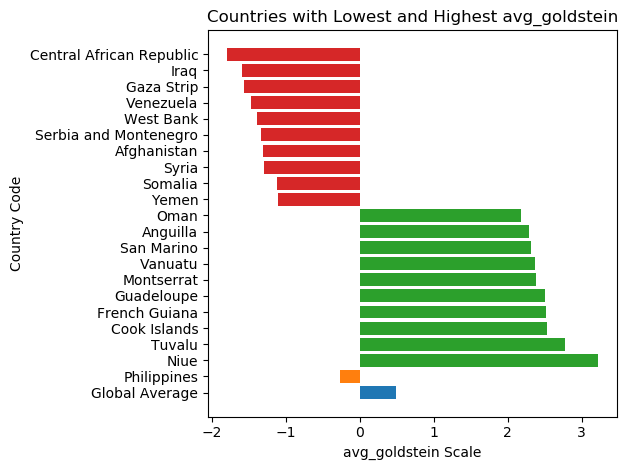

In [89]:
# Plot avg goldstein for the whole 3 month period May June Jul 2017
plot_barchart(df_by_country, 'avg_goldstein')

> 230 locations in the dataset
> Sorted according to avg_avgtone and reset index
> loaded Philippines value


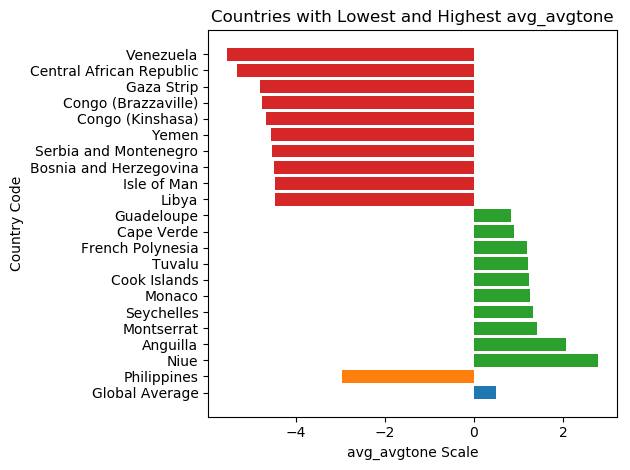

In [90]:
# Plot avg tone for the whole 3 month period May June Jul 2017
plot_barchart(df_by_country, 'avg_avgtone')

### Goldstein and Average Tone per Coordinate

In [25]:
# Get a sample for plotting 
frac = 0.01
df_events_sample = df_.sample(frac=frac).persist()
print(f"> Obtained a {frac} sample for plotting.")
print("> Selected data persisted into workers.")

> Obtained a 0.01 sample for plotting.
> Selected data persisted into workers.


In [26]:
# Save sample to csv
df_events_sample.compute().to_csv("data/df_events_sample_coord.csv")
print("> df_events_sample_coord saved to csv")

> df_events_sample_coord saved to csv


In [27]:
# Load df_events_sample.csv
df_events_sample = pd.read_csv("data/df_events_sample_coord.csv")
df_events_sample.head()

,GlobalEventID,Day,MonthYear,GoldsteinScale,NumMentions,NumSources,NumArticles,AvgTone,Actor1Geo_Lat,Actor1Geo_Long,Actor1Geo_CountryCode,Actor1Geo_Fullname,goldstein * num_mentions,avgtone * num_mentions
0,651554801,20170501.0,201705.0,3.4,2.0,1.0,2.0,3.720930,6.41667,2.88333,NI,"Badagry, Lagos, Nigeria",6.8,7.441860
1,651555864,20170501.0,201705.0,0.0,2.0,1.0,2.0,-1.620746,39.01940,125.75500,KN,"Pyongyang, P'yongyang-si, North Korea",0.0,-3.241491
2,651554398,20170501.0,201705.0,-2.0,4.0,1.0,4.0,-8.097166,NaN,NaN,NaN,NaN,-8.0,-32.388664
3,651555218,20170501.0,201705.0,1.0,2.0,1.0,2.0,-5.263158,35.84690,38.54430,SY,"Tabqa, Ar Raqqah, Syria",2.0,-10.526316
4,651554564,20170501.0,201705.0,-2.0,10.0,1.0,10.0,1.926164,13.00000,105.00000,CB,Cambodia,-20.0,19.261637


In [28]:
# Plot the longitudes and latitudes color coded according to Goldstein value
y = df_events_sample['Actor1Geo_Lat']
x = df_events_sample['Actor1Geo_Long']
goldstein = df_events_sample['GoldsteinScale']
avgtone = df_events_sample['AvgTone']
num_mentions = df_events_sample['NumMentions']
print("> Coordinates and other valuable data to be visualized computed successfully.")

> Coordinates and other valuable data to be visualized computed successfully.


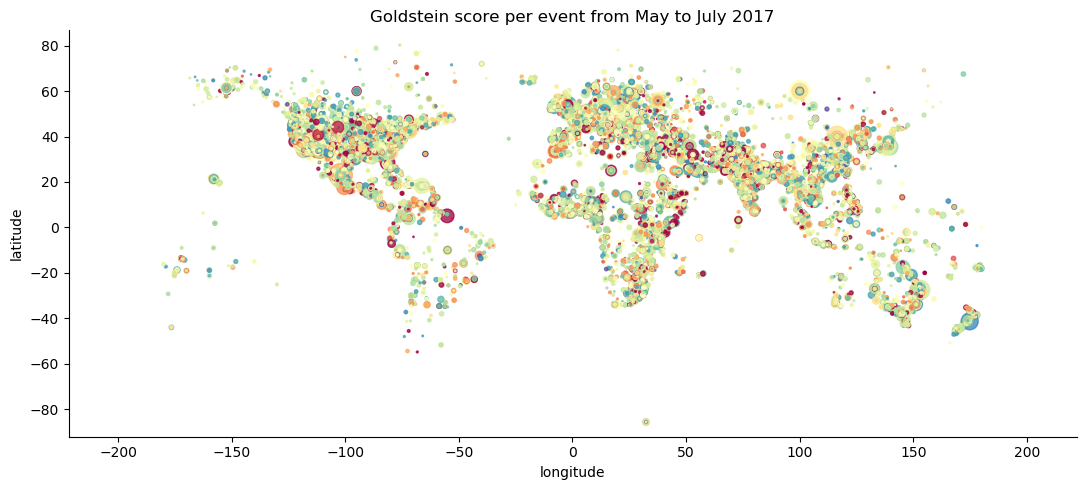

In [69]:
# Goldstein values vs Latitude and Longitude
# Color is goldstein while size is importance (num_mentions)
plt.style.use('default')
f, ax = plt.subplots(figsize=(11,5))
ax.scatter(x, y, c=goldstein, marker='o', s=num_mentions, cmap='Spectral', alpha=0.75)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.axis('equal')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('Goldstein score per event from May to July 2017')
plt.tight_layout()

# Save figure
plt.savefig("charts/goldstein_world.png", dpi=150)

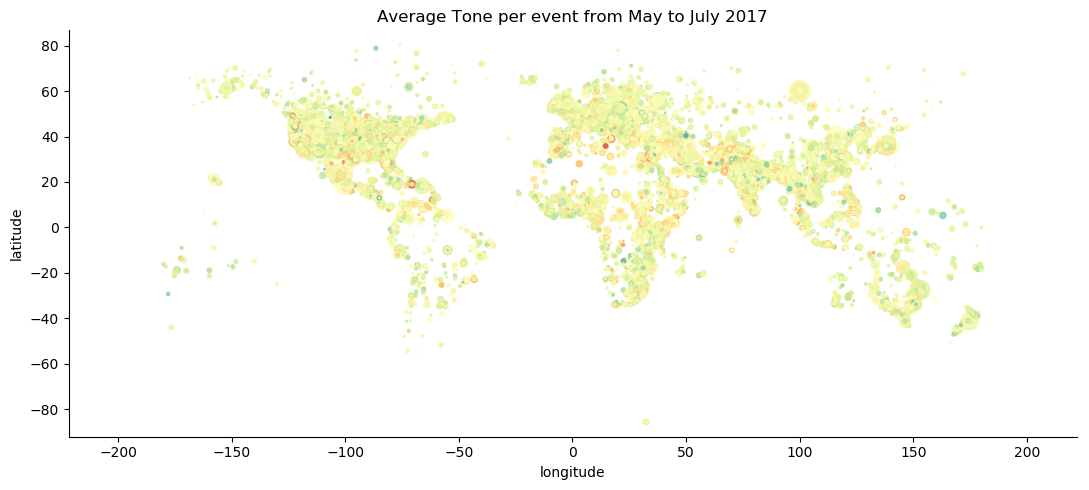

In [68]:
# AvgTone values vs Latitude and Longitude
# Color is avg tone while size is importance (num_mentions)
f, ax = plt.subplots(figsize=(11,5))
ax.scatter(x, y, c=avgtone, marker='o', s=num_mentions, cmap='Spectral', alpha=0.75)
plt.axis('equal')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('Average Tone per event from May to July 2017')
plt.tight_layout()

# Save figure
plt.savefig("charts/avgtone_world.png", dpi=150)

### Goldstein and Average Tone per Coordinate in the Philippines

In [ ]:
# Filter Philippines dataframe
df_ph = df_[df_.Actor1Geo_CountryCode == 'RP']
print("> Selected Philippines and successfully computed")

In [133]:
# Save to csv
df_ph.compute().to_csv("data/df_ph_coord.csv")
print("> Successfully saved Ph sample to csv")

> Successfully saved Ph sample to csv


In [134]:
# Load
df_ph = pd.read_csv("data/df_ph_coord.csv")

In [135]:
# Get Latitude and Longitude
y2 = df_ph['Actor1Geo_Lat']
x2 = df_ph['Actor1Geo_Long']
print("> Coordinates to be visualized computed successfully.")

> Coordinates to be visualized computed successfully.


In [136]:
df_ph.head()

,GlobalEventID,Day,MonthYear,GoldsteinScale,NumMentions,NumSources,NumArticles,AvgTone,Actor1Geo_Lat,Actor1Geo_Long,Actor1Geo_CountryCode,Actor1Geo_Fullname,goldstein * num_mentions,avgtone * num_mentions
0,651554620,20170501.0,201705.0,0.0,8.0,1.0,8.0,0.281690,7.07306,125.613,RP,"Davao, Davao City, Philippines",0.0,2.253521
1,651554629,20170501.0,201705.0,-2.0,2.0,1.0,2.0,0.281690,7.07306,125.613,RP,"Davao, Davao City, Philippines",-4.0,0.563380
2,651554633,20170501.0,201705.0,1.0,2.0,1.0,2.0,-3.225806,13.00000,122.000,RP,Philippines,2.0,-6.451613
3,651555083,20170501.0,201705.0,3.5,8.0,1.0,8.0,0.281690,7.07306,125.613,RP,"Davao, Davao City, Philippines",28.0,2.253521
4,651555310,20170501.0,201705.0,4.0,10.0,1.0,10.0,-2.056075,13.00000,122.000,RP,Philippines,40.0,-20.560748


In [138]:
# Get goldstein and avgtone values
goldstein2 = df_ph['GoldsteinScale']
avgtone2 = df_ph['GoldsteinScale']
num_mentions2 = df_ph['NumMentions']
print("> Other valuable data to be visualized computed successfully.")

> Other valuable data to be visualized computed successfully.


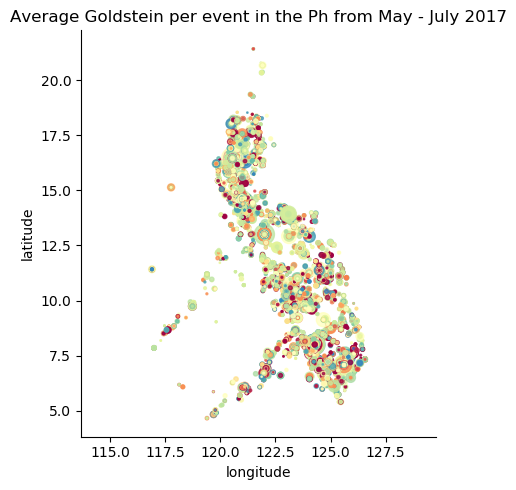

In [139]:
# Goldstein values vs Latitude and Longitude
# Color is goldstein while size is importance (num_mentions)
plt.style.use('default')
f, ax = plt.subplots(figsize=(5,5))
ax.scatter(x2, y2, c=goldstein2, marker='o', s=num_mentions2, cmap='Spectral', alpha=0.75)
plt.axis('equal')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('Average Goldstein per event in the Ph from May - July 2017')
plt.tight_layout()
plt.savefig('charts/scatter_goldstein_ph.png', dpi=150)

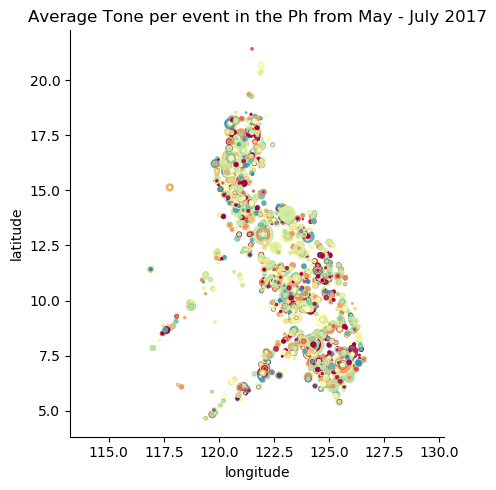

In [140]:
# AvgTone values vs Latitude and Longitude
# Color is goldstein while size is importance (num_mentions)
f, ax = plt.subplots(figsize=(5,5))
ax.scatter(x2, y2, c=avgtone2, marker='o', s=num_mentions2, cmap='Spectral', alpha=0.75)
plt.axis('equal')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('Average Tone per event in the Ph from May - July 2017')
plt.tight_layout()
plt.savefig('charts/scatter_avgtone_ph.png', dpi=150)

## Methodology

< Complete methodology stated, described and justified>

## Results

< results presented are clean, robust and relevant that will allow a strong
answer or solution to the stated problem>

< explicit answer to the stated problem and presented interesting insights on
that can be traced back to the methods and discussion results >

## References

http://web.pdx.edu/~kinsella/jgscale.html

## Acknowledgements

## Test Code